# Notebook to forecast quantiles for the DAX

## Imports

In [4]:
import pandas as pd
import numpy as np
import statsmodels as sm
import yfinance as yf
from datetime import datetime
import requests
import json
import sys

#from darts.models.forecasting.exponential_smoothing import ExponentialSmoothing
#from darts.utils.likelihood_models import GaussianLikelihood
#from darts.timeseries import TimeSeries

pd.set_option('display.max_columns', 500)
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', sys.maxsize)

## Functions

In [5]:
def compute_return(y, r_type="log", h=1):
    
    # exclude first h observations
    y2 = y[h:]
    # exclude last h observations
    y1 = y[:-h]
    
    if r_type == "log":
        ret = np.concatenate(([np.nan]*h, 100 * (np.log(y2) - np.log(y1))))
    else:
        ret = np.concatenate(([np.nan]*h, 100 * (y2-y1)/y1))
        
    return ret

In [6]:
def create_submission_table():
    forecast_date = [str(datetime.datetime.now().date())] * 16
    target = ["DAX"] * 5 + ["energy"] * 6 + ["wind"] * 5
    horizon = ['1 day', '2 day', '5 day', '6 day', '7 day', '36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour', '36 hour', '48 hour', '60 hour', '72 hour', '84 hour']
    
    return pd.DataFrame({"forecast_date": forecast_date, "target": target, "horizon": horizon, "q0.025": [np.nan]*16, "q0.25": [np.nan]*16, "q0.5": [np.nan]*16, "q0.75": [np.nan]*16, "q0.975": [np.nan]*16})

In [7]:
def get_dax_data():
    msft = yf.Ticker("^GDAXI")
    hist = msft.history(period="max")
    data = hist[["Close"]]
    data = compute_return(data.Close.values)
    data = data[1:]
    
    return data

In [149]:
def get_energy_data():
    data = pd.read_csv("energy_data.csv", sep=";")
    data = data[data.columns[:3]]
    data = data.rename(columns={"Gesamt (Netzlast)[MWh]": "Gesamt"})
    data = data[data["Gesamt"] != "-"]
    data["date_time"] = pd.to_datetime(data['Datum'] + ' ' + data['Uhrzeit'], format = '%d.%m.%Y %H:%M')
    data = data.drop(columns = ["Datum", "Uhrzeit"])
    data = data.astype({"Gesamt": float})
    data.set_index("date_time", inplace=True)
    data = data.resample("1h", label = "right").sum()
    data = data.Gesamt.values
    
    return data

## Modeling

### DAX

In [175]:
prob_model = ExponentialSmoothing()

In [176]:
prob_model = prob_model.fit(TimeSeries.from_values(rets))

/usr/local/Caskroom/miniconda/base/envs/unienv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [177]:
pred = prob_model.predict(5, num_samples=100)

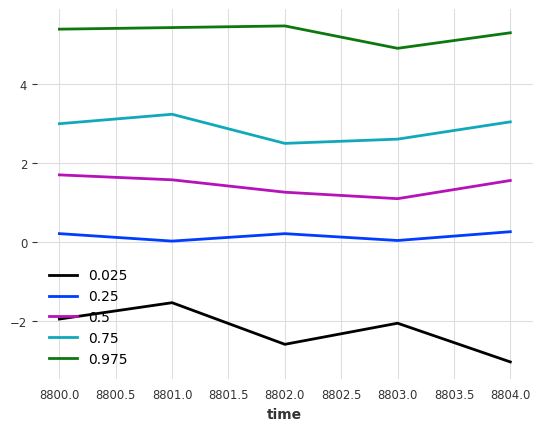

In [178]:
pred.quantile_timeseries(0.025).plot(label = "0.025")
pred.quantile_timeseries(0.25).plot(label = "0.25")
pred.quantile_timeseries(0.5).plot(label = "0.5")
pred.quantile_timeseries(0.75).plot(label = "0.75")
pred.quantile_timeseries(0.975).plot(label = "0.975")

In [179]:
sub = pd.DataFrame({"q0.025": pred.quantile_timeseries(0.025).pd_series(),
                   "q0.25": pred.quantile_timeseries(0.25).pd_series(),
                   "q0.5": pred.quantile_timeseries(0.5).pd_series(),
                   "q0.75": pred.quantile_timeseries(0.75).pd_series(),
                   "q0.975": pred.quantile_timeseries(0.975).pd_series()})

In [180]:
sub = sub.reset_index().drop(columns = "time")

In [181]:
sub["forecast_date"] = "2022-10-26"
sub["target"] = "DAX"
sub["horizon"] = ["1 day", "2 day", "5 day", "6 day", "7 day"]

In [182]:
sub = sub[["forecast_date", "target", "horizon", "q0.025", "q0.25", "q0.5", "q0.75", "q0.975"]]

In [183]:
nans = pd.Series(["2022-10-26", "energy", None, None, None, None, None, None], index = sub.columns)
for i in range(6):
    sub = sub.append(nans, ignore_index = True)

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/1045233296.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(nans, ignore_index = True)


In [184]:
nans = pd.Series(["2022-10-26", "wind", None, None, None, None, None, None], index = sub.columns)
for i in range(5):
    sub = sub.append(nans, ignore_index = True)

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/4031082620.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sub = sub.append(nans, ignore_index = True)


In [190]:
sub.horizon.iloc[5:11] = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/2573154423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.horizon.iloc[5:11] = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']


In [194]:
sub.horizon.iloc[11:16] = ['36 hour', '48 hour', '60 hour', '72 hour', '84 hour']

/var/folders/g6/cmh9kt9x26db790xkfg9b3y40000gn/T/ipykernel_54084/2441354173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub.horizon.iloc[11:16] = ['36 hour', '48 hour', '60 hour', '72 hour', '84 hour']


In [195]:
sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2022-10-26,DAX,1 day,-1.944848,0.216140,1.702465,2.997505,5.389528
1,2022-10-26,DAX,2 day,-1.531212,0.027386,1.577861,3.236119,5.429700
2,2022-10-26,DAX,5 day,-2.584560,0.215435,1.264385,2.499556,5.471471
3,2022-10-26,DAX,6 day,-2.050316,0.042469,1.100540,2.606875,4.904985
4,2022-10-26,DAX,7 day,-3.029857,0.264885,1.560649,3.044176,5.297935
5,2022-10-26,energy,36 hour,NaN,NaN,NaN,NaN,NaN
6,2022-10-26,energy,40 hour,NaN,NaN,NaN,NaN,NaN
7,2022-10-26,energy,44 hour,NaN,NaN,NaN,NaN,NaN
8,2022-10-26,energy,60 hour,NaN,NaN,NaN,NaN,NaN
9,2022-10-26,energy,64 hour,NaN,NaN,NaN,NaN,NaN


In [196]:
sub.to_csv("20221026_GreyWorm.csv", index = False)

In [197]:
! python check.py -p 20221026_GreyWorm.csv

{'path': '20221026_GreyWorm.csv', 'exclude_weather': None}
Loading file... 20221026_GreyWorm.csv
File loaded! Start Checking...
---------------------------
Checking the Columns...
Checking type of columns...
----WARNING: Some elements in q0.025 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.25 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.5 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.75 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

----WARNING: Some elements in q0.975 column are not numeric. This may be fine if you only submit 2 out of 3 targets.

Checking if the Dates make sense...
Checking targets...
Checking quantiles...
Assume that -- energy -- is your NaN-target. Please DOUBLECHECK if this is correct.
Your dataframe contains more NaNs than entri

### Energy